# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

### About CNNs
Convolutional layers extract features - quantitative representations of some attributes.

After the extraction you can use these features for classification, for example.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/act.png?raw=1" width="800">

#### Convolution:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/convolution.gif?raw=1" width="400">

### Pooling:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/pooling.gif?raw=1" width="400">


## Deeper layer $\to$ more complex features.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/feat.png?raw=1" width="800">

# Task: Cats vs. Dogs Classification

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/cat_dog_sota.jpg?raw=1" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading instead of the latter one.

In [1]:
# Uncomment only on google collab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Training set with 11K images
#!ls "/drive/MyDrive/data.zip"
#! unzip -n -qq data.zip -d data
! unzip "/content/drive/MyDrive/data.zip"
! mkdir img
! wget -nc https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_1.png -P img
! wget -nc https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_2.png -P img

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_11k/dog/dog.11226.jpg  
  inflating: train_11k/dog/dog.11227.jpg  
  inflating: train_11k/dog/dog.11229.jpg  
  inflating: train_11k/dog/dog.11232.jpg  
  inflating: train_11k/dog/dog.11234.jpg  
  inflating: train_11k/dog/dog.11239.jpg  
  inflating: train_11k/dog/dog.1124.jpg  
  inflating: train_11k/dog/dog.11240.jpg  
  inflating: train_11k/dog/dog.11243.jpg  
  inflating: train_11k/dog/dog.11245.jpg  
  inflating: train_11k/dog/dog.11246.jpg  
  inflating: train_11k/dog/dog.11249.jpg  
  inflating: train_11k/dog/dog.11250.jpg  
  inflating: train_11k/dog/dog.11253.jpg  
  inflating: train_11k/dog/dog.11254.jpg  
  inflating: train_11k/dog/dog.11256.jpg  
  inflating: train_11k/dog/dog.11259.jpg  
  inflating: train_11k/dog/dog.11262.jpg  
  inflating: train_11k/dog/dog.11263.jpg  
  inflating: train_11k/dog/dog.11264.jpg  
  inflating: train_11k/dog/dog.11265.jpg  
  inflating: train_11k/dog/dog

Now let's look at the way datasets are processed in PyTorch.

In [3]:
!pip install torchinfo

In [4]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
device.type, device.index, str(device)

('cuda', None, 'cuda')

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [7]:
# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96  # 128 / 192
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# B G R
# Images mean and std channelwise : ImageNet DB
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

ToTensor operations:
- convert from numpy to pytorch
- move channels dimension from last position to first
- convert integer representation to float32

In [8]:
transformer = transforms.Compose(
    [
        transforms.Resize((SIZE_H, SIZE_W)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Normalize(image_mean, image_std),  # normalize image data per-channel
    ]
)

Create an ImageFolder instance to be used during training, validation and testing phases.

Pathlib documentation
https://docs.python.org/3/library/pathlib.html

In [9]:
from pathlib import Path

In [10]:
# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = Path("/").resolve()
DATA_PATH

PosixPath('/')

In [11]:
train_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/train_11k", transform=transformer
)
val_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/val", transform=transformer
)
test_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/test_labeled", transform=transformer
)

In [12]:
# print(len(train_dataset) * np.multiply(*train_dataset[0][0].size))
len(train_dataset), train_dataset[0][0].shape

(11250, torch.Size([3, 96, 96]))

In [13]:
# Train dataset size
11250 * 3 * 96 * 96 * 32 / 8 / 2**10 / 2**10 / 2**10 # Gb

1.1587142944335938

In [14]:
train_dataset.class_to_idx

{'cat': 0, 'dog': 1}

Save sample num for further use

In [15]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)
n_train, n_val, n_test

(11250, 2500, 12494)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [16]:
# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Number of threads for data loader
NUM_WORKERS = 2 # 2 is optimal for google colab, for local machine use 4

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [18]:
def plot_from_loader(loader):
    iterator = iter(loader)
    data_batch, label_batch = next(iterator)
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15, 10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = "Label = %d (%s)" % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

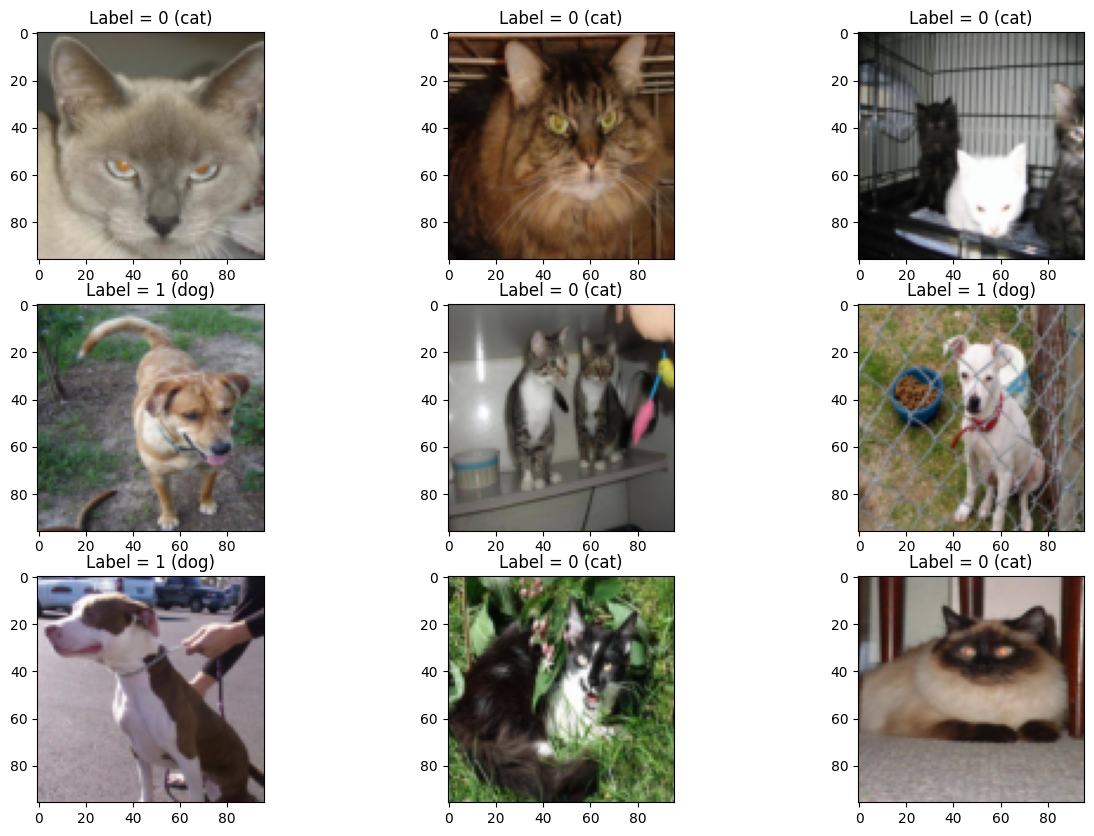

In [19]:
plot_from_loader(train_loader)

# Building training pipeline

Training function is same to which we used on previous seminar

In [20]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    top_val_accuracy = -1
    best_model = None

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        ### TRAINING PHASE
        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            # X_batch.cuda() - highly not recommended!
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            ## FORWARD PASS
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predicts = model(X_batch)
            loss = loss_fn(predicts, y_batch)
            ## <\FORWARD PASS>

            ## BACKWARD PASS
            loss.backward()
            opt.step()
            ## </BACKWARD PASS>
            ep_train_loss.append(loss.item())

        ### VALIDATION PHASE
        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad(): # alternatively https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                preds = model(X_batch)
                validation_loss = loss_fn(preds, y_batch)

                ep_val_loss.append(validation_loss.item())
                # y_pred = preds.max(1)[1].data
                preds_np = np.argmax(preds.detach().cpu().numpy(), 1).ravel()
                gt = y_batch.detach().cpu().numpy().ravel()
                hits = np.array(preds_np == gt)
                ep_val_accuracy.append(hits.astype(np.float32).mean())

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {100 * val_accuracy[-1]:.1f}")
        if val_accuracy[-1] > top_val_accuracy:
            best_model = model

    return train_loss, val_loss, val_accuracy, best_model

In [21]:
@torch.no_grad()
def test_model(model, test_loader, subset="test"):
    model.train(False)  # disable dropout / use averages for batch_norm
    test_batch_acc = []

    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    test_accuracy = np.mean(test_batch_acc)

    print("Results:")
    print(f"    {subset} accuracy: {test_accuracy * 100:.2f} %")

    if test_accuracy > 0.9:
        print("  Amazing!")
    elif test_accuracy > 0.7:
        print("  Good!")
    else:
        print("  We need more magic! Follow instructons below")

    return test_accuracy

## Task 0: Multi-layer fully-connected network

Look at the NN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [22]:
N_CHANNELS * SIZE_H * SIZE_W

27648

In [23]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.Linear(128, NUM_CLASSES),
    nn.Softmax(dim=1),
)

model = model.to(device)

Print model summary for sanity check:

In [24]:
!nvidia-smi

Mon Jan 27 23:39:12 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              26W /  70W |    133MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
summary(model, (1, N_CHANNELS, SIZE_H, SIZE_W), device=device)
# [27648 x 256]

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Flatten: 1-1                           [1, 27648]                --
├─Linear: 1-2                            [1, 256]                  7,078,144
├─ReLU: 1-3                              [1, 256]                  --
├─Linear: 1-4                            [1, 128]                  32,896
├─ReLU: 1-5                              [1, 128]                  --
├─Linear: 1-6                            [1, 2]                    258
├─Softmax: 1-7                           [1, 2]                    --
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.11
Input size (MB): 0.11
Forward/backward pass size (MB): 0.00
Params size (MB): 28.45
Estimated Total Size (MB): 28.56

## Training

* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead
* For visualization purposes we propose to plot train/val loss graphs and validation score distribution for CNN predictions over images of cats (class_0) and dogs (class_1).

In [26]:
loss_fn = nn.CrossEntropyLoss()

In [27]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model = train_model(
    model, train_loader, val_loader, loss_fn, opt, 5
)

Epoch 1 of 5 took 48.812s
	  training loss: 0.723019
	validation loss: 0.753275
	validation accuracy: 55.7
Epoch 2 of 5 took 40.983s
	  training loss: 0.705297
	validation loss: 0.749309
	validation accuracy: 56.1
Epoch 3 of 5 took 36.009s
	  training loss: 0.702671
	validation loss: 0.741831
	validation accuracy: 56.8
Epoch 4 of 5 took 38.076s
	  training loss: 0.694749
	validation loss: 0.755209
	validation accuracy: 55.6
Epoch 5 of 5 took 34.249s
	  training loss: 0.697046
	validation loss: 0.746892
	validation accuracy: 56.3


In [28]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()
    axes[0].grid()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)
    axes[1].grid()

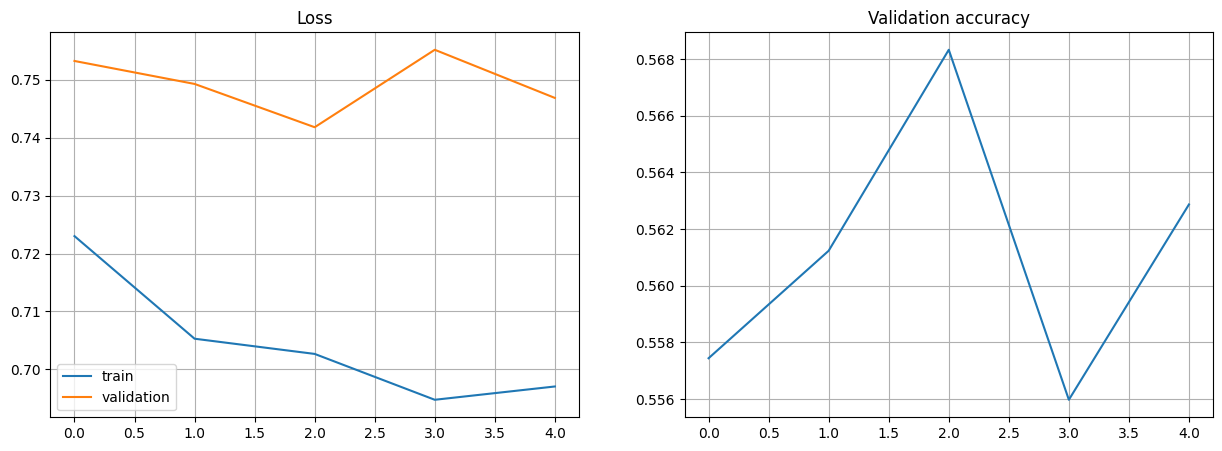

In [29]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluate the best model using test set

In [30]:
val_stats = test_model(best_model, val_loader, "validation")
test_stats = test_model(best_model, test_loader, "test")

Results:
    validation accuracy: 56.29 %
  We need more magic! Follow instructons below
Results:
    test accuracy: 58.11 %
  We need more magic! Follow instructons below


# Task I: small convolution net
## First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4 classic convolutional blocks `convolution->relu->pool`:
  * 3x3 convolution with 32 -> 32 -> 64 -> 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout
* Dense layer with 128 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

__HACK_OF_THE_DAY_3__  : it might be useful to use 'VGG-like' structure as a baseline for this task:
    * every CNN layer with 2x2 maxpooling / stride=2 should be followed by increasing the number of output channels x2
    * before the fully-connected layer the tensor H and W should be relatively small (less than 10)
    * in other words, the less H and W of tensor are, the more should you increase C in order to keep more information

LazyLinear layer:\
https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html

In [31]:
# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [32]:
model_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(6),
    nn.Flatten(),
    nn.LazyLinear(EMBEDDING_SIZE),
    nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False),
    nn.Softmax(dim=1),
)

model_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=6)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): LazyLinear(in_features=0, out_features=256, bias=True)
  (13): Linear(in_features=256, out_features=2, bias=False)
  (14): Softmax(dim=1)
)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [33]:
summary(model_cnn, (BATCH_SIZE, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256, 2]                  --
├─Conv2d: 1-1                            [256, 32, 48, 48]         896
├─ReLU: 1-2                              [256, 32, 48, 48]         --
├─Conv2d: 1-3                            [256, 64, 48, 48]         18,496
├─ReLU: 1-4                              [256, 64, 48, 48]         --
├─Conv2d: 1-5                            [256, 64, 24, 24]         36,928
├─ReLU: 1-6                              [256, 64, 24, 24]         --
├─Conv2d: 1-7                            [256, 128, 24, 24]        73,856
├─ReLU: 1-8                              [256, 128, 24, 24]        --
├─Conv2d: 1-9                            [256, 128, 12, 12]        147,584
├─ReLU: 1-10                             [256, 128, 12, 12]        --
├─AdaptiveAvgPool2d: 1-11                [256, 128, 6, 6]          --
├─Flatten: 1-12                          [256, 4608]               

## Training

We may use the same training pipeline, that we defined above, as it does not depend on model structure.

In [35]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_cnn = train_model(
    model_cnn, train_loader, val_loader, loss_fn, opt, 10
)

Epoch 1 of 10 took 39.093s
	  training loss: 0.645993
	validation loss: 0.663012
	validation accuracy: 60.5
Epoch 2 of 10 took 40.243s
	  training loss: 0.601246
	validation loss: 0.671882
	validation accuracy: 61.3
Epoch 3 of 10 took 39.666s
	  training loss: 0.570488
	validation loss: 0.589113
	validation accuracy: 70.1
Epoch 4 of 10 took 38.653s
	  training loss: 0.546984
	validation loss: 0.598321
	validation accuracy: 69.6
Epoch 5 of 10 took 36.935s
	  training loss: 0.523627
	validation loss: 0.562565
	validation accuracy: 73.9
Epoch 6 of 10 took 36.213s
	  training loss: 0.507397
	validation loss: 0.545146
	validation accuracy: 75.2
Epoch 7 of 10 took 36.412s
	  training loss: 0.490585
	validation loss: 0.532475
	validation accuracy: 77.0
Epoch 8 of 10 took 40.302s
	  training loss: 0.483332
	validation loss: 0.548640
	validation accuracy: 75.1
Epoch 9 of 10 took 37.362s
	  training loss: 0.480291
	validation loss: 0.524698
	validation accuracy: 77.6
Epoch 10 of 10 took 36.323s


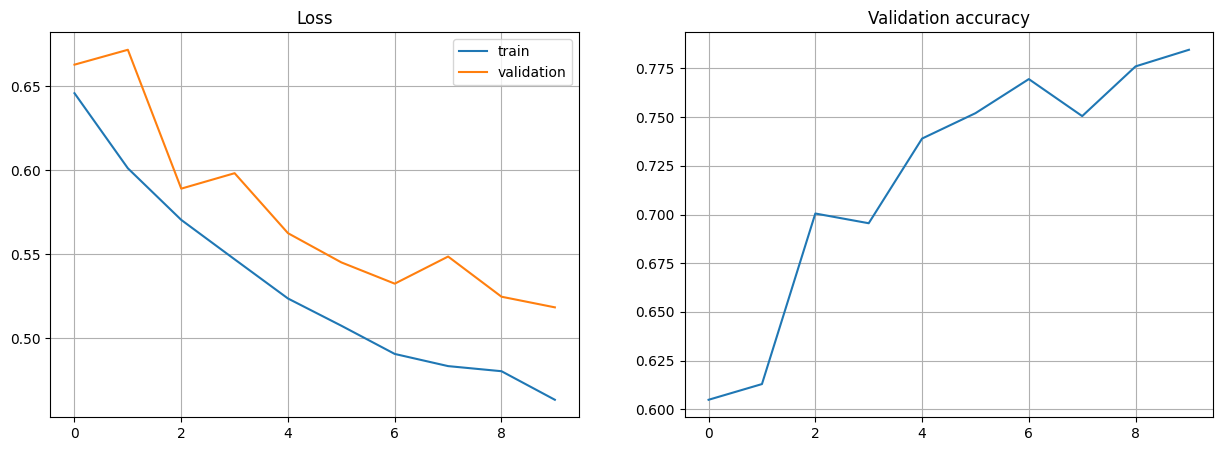

In [36]:
plot_train_process(train_loss, val_loss, val_accuracy)

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

## Evaluation


In [37]:
val_stats = test_model(best_model_cnn, val_loader, "validation")
test_stats = test_model(best_model_cnn, test_loader, "test")

Results:
    validation accuracy: 78.46 %
  Good!
Results:
    test accuracy: 80.63 %
  Good!


### A bit better conv model

TODO: make batch size bigger!

In [38]:
model_better_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(6),
    nn.Flatten(),
    nn.LazyLinear(128),
    nn.Dropout(0.5),
    nn.LazyLinear(NUM_CLASSES, bias=False),
    nn.Softmax(dim=1),
)

model_better_cnn.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): AdaptiveAvgPool2d(output_size=6)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): LazyLinear(in_features=0, out_features=128, bias=True)
  (16): Dropout(p=0.5, inplace=False)
  (17): LazyLinear(in_features=0, out_features=2, bias=False)
  (18): Softmax(dim=1)
)

In [39]:
summary(model_better_cnn, (BATCH_SIZE, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256, 2]                  --
├─Conv2d: 1-1                            [256, 32, 96, 96]         896
├─BatchNorm2d: 1-2                       [256, 32, 96, 96]         64
├─ReLU: 1-3                              [256, 32, 96, 96]         --
├─Conv2d: 1-4                            [256, 64, 96, 96]         18,496
├─ReLU: 1-5                              [256, 64, 96, 96]         --
├─Conv2d: 1-6                            [256, 64, 48, 48]         36,928
├─BatchNorm2d: 1-7                       [256, 64, 48, 48]         128
├─ReLU: 1-8                              [256, 64, 48, 48]         --
├─Conv2d: 1-9                            [256, 128, 48, 48]        73,856
├─ReLU: 1-10                             [256, 128, 48, 48]        --
├─Conv2d: 1-11                           [256, 128, 24, 24]        147,584
├─BatchNorm2d: 1-12                      [256, 128, 24, 24]       

In [40]:
opt = torch.optim.Adam(model_better_cnn.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_better_cnn = train_model(
    model_better_cnn, train_loader, val_loader, loss_fn, opt, 10
)

Epoch 1 of 10 took 42.408s
	  training loss: 0.811165
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 2 of 10 took 40.855s
	  training loss: 0.813205
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 3 of 10 took 41.190s
	  training loss: 0.813354
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 4 of 10 took 39.109s
	  training loss: 0.813282
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 5 of 10 took 42.441s
	  training loss: 0.813277
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 6 of 10 took 40.847s
	  training loss: 0.813277
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 7 of 10 took 39.263s
	  training loss: 0.813262
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 8 of 10 took 40.362s
	  training loss: 0.813303
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 9 of 10 took 43.574s
	  training loss: 0.813231
	validation loss: 0.801543
	validation accuracy: 51.2
Epoch 10 of 10 took 39.681s


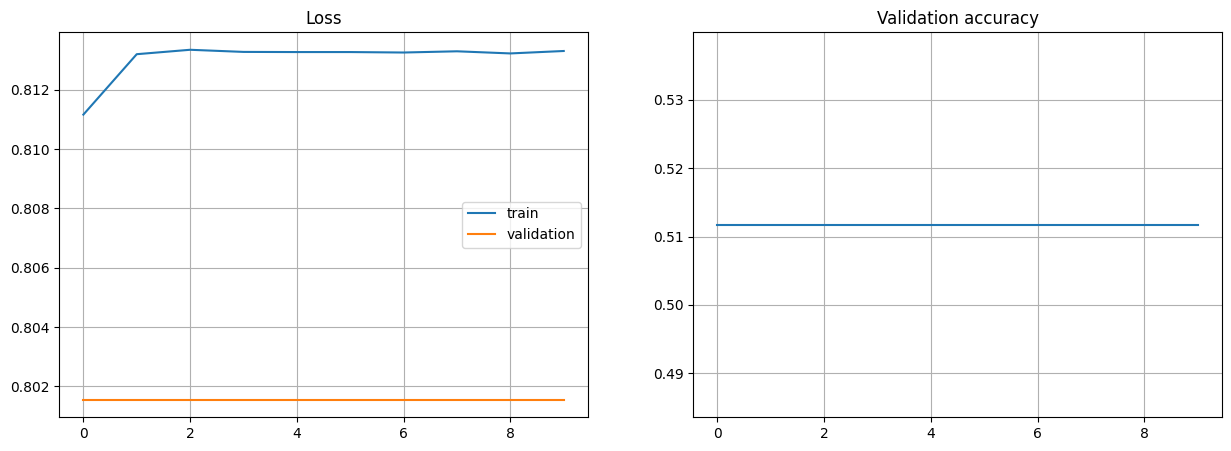

In [41]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Task 2: Fine-tuning

## In practice it is easier to use pre-trained NN

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/ft.jpg?raw=1" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/resnet.png?raw=1" width="800">

In [42]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
for p in model_resnet18.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, NUM_CLASSES, bias=False)

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [43]:
summary(model_resnet18, (1, N_CHANNELS, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 48, 48]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 48, 48]           (128)
├─ReLU: 1-3                              [1, 64, 48, 48]           --
├─MaxPool2d: 1-4                         [1, 64, 24, 24]           --
├─Sequential: 1-5                        [1, 64, 24, 24]           --
│    └─BasicBlock: 2-1                   [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                  [1, 64, 24, 24]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 24, 24]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-4                  [1, 64, 24, 24]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 24, 24]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 24, 24]   

## Training (only for final layer)

In [44]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)

train_loss, val_loss, val_accuracy, best_model_resnet18 = train_model(
    model_resnet18, train_loader, val_loader, loss_fn, opt_resnet, 10
)

Epoch 1 of 10 took 35.762s
	  training loss: 0.455906
	validation loss: 0.388854
	validation accuracy: 81.2
Epoch 2 of 10 took 35.180s
	  training loss: 0.324187
	validation loss: 0.359112
	validation accuracy: 84.1
Epoch 3 of 10 took 37.203s
	  training loss: 0.302238
	validation loss: 0.337536
	validation accuracy: 84.8
Epoch 4 of 10 took 38.021s
	  training loss: 0.291531
	validation loss: 0.334711
	validation accuracy: 84.7
Epoch 5 of 10 took 37.137s
	  training loss: 0.280302
	validation loss: 0.341845
	validation accuracy: 84.7
Epoch 6 of 10 took 35.583s
	  training loss: 0.279236
	validation loss: 0.323264
	validation accuracy: 85.4
Epoch 7 of 10 took 36.190s
	  training loss: 0.276283
	validation loss: 0.321204
	validation accuracy: 85.1
Epoch 8 of 10 took 38.271s
	  training loss: 0.274046
	validation loss: 0.333644
	validation accuracy: 85.5
Epoch 9 of 10 took 36.228s
	  training loss: 0.269621
	validation loss: 0.318848
	validation accuracy: 85.3
Epoch 10 of 10 took 36.027s


## Evaluation

In [45]:
val_stats = test_model(best_model_resnet18, val_loader, "validation")
test_stats = test_model(best_model_resnet18, test_loader, "test")

Results:
    validation accuracy: 85.09 %
  Good!
Results:
    test accuracy: 86.53 %
  Good!


## Use your own image

In [46]:
from skimage.io import imread
from skimage.transform import resize


src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode="reflect")
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode="reflect")

# convert to torch.Tensor
tensor_1 = torch.Tensor(
    np.transpose((resized_1 / 255 - image_mean) / image_std, [2, 0, 1])[np.newaxis, :, :, :]
).to(device)
tensor_2 = torch.Tensor(
    np.transpose((resized_2 / 255 - image_mean) / image_std, [2, 0, 1])[np.newaxis, :, :, :]
).to(device)

# 'cat' scores
score_1 = F.softmax(best_model_resnet18(tensor_1), 1)[0][0].detach().cpu().numpy()
score_2 = F.softmax(best_model_resnet18(tensor_2), 1)[0][0].detach().cpu().numpy()

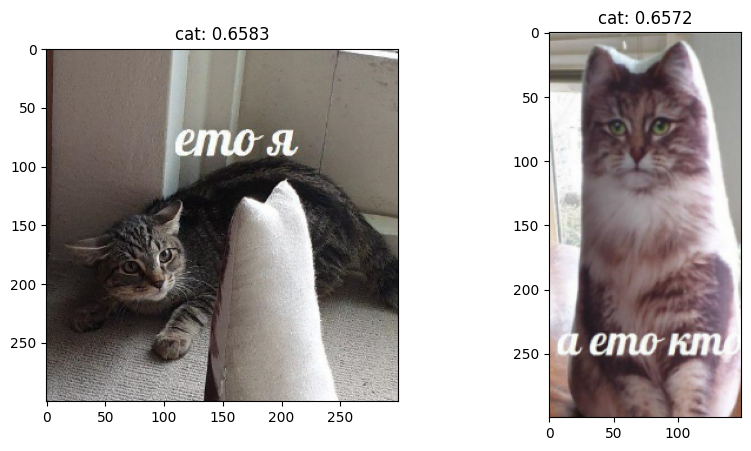

In [47]:
get_label = lambda x: ("cat" if x > 0.5 else "dog") + ": {:.4f}".format(x)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


# Task 3: adding normalization and different model initialization
## Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [48]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )


class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            conv_block_3x3(3, 64),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            conv_block_3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv_block_3x3(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, EMBEDDING_SIZE, bias=False),
            nn.BatchNorm1d(EMBEDDING_SIZE),
            nn.ReLU(),
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False), nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x


In [49]:
# outputs are here for convenience
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (BATCH_SIZE, N_CHANNELS, SIZE_H, SIZE_W), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [256, 2]                  --
├─Sequential: 1-1                        [256, 128]                --
│    └─Sequential: 2-1                   [256, 64, 96, 96]         --
│    │    └─Conv2d: 3-1                  [256, 64, 96, 96]         1,728
│    │    └─BatchNorm2d: 3-2             [256, 64, 96, 96]         128
│    │    └─ReLU: 3-3                    [256, 64, 96, 96]         --
│    └─MaxPool2d: 2-2                    [256, 64, 48, 48]         --
│    └─BatchNorm2d: 2-3                  [256, 64, 48, 48]         128
│    └─ReLU: 2-4                         [256, 64, 48, 48]         --
│    └─Sequential: 2-5                   [256, 64, 48, 48]         --
│    │    └─Conv2d: 3-4                  [256, 64, 48, 48]         36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 48, 48]         128
│    │    └─ReLU: 3-6                    [256, 64, 48, 48]         --
│    

## Training

In [50]:
model_cnn_norm = model_cnn_norm.to(device)
opt_norm = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
opt_norm.zero_grad()

train_loss, val_loss, val_accuracy, best_model_norm = train_model(
    model_cnn_norm, train_loader, val_loader, loss_fn, opt_norm, 10
)

Epoch 1 of 10 took 37.615s
	  training loss: 0.601901
	validation loss: 0.639134
	validation accuracy: 63.6
Epoch 2 of 10 took 41.137s
	  training loss: 0.542363
	validation loss: 0.620089
	validation accuracy: 67.8
Epoch 3 of 10 took 37.805s
	  training loss: 0.519682
	validation loss: 0.562497
	validation accuracy: 73.0
Epoch 4 of 10 took 43.046s
	  training loss: 0.503108
	validation loss: 0.610971
	validation accuracy: 67.9
Epoch 5 of 10 took 38.661s
	  training loss: 0.487542
	validation loss: 0.549581
	validation accuracy: 74.8
Epoch 6 of 10 took 40.874s
	  training loss: 0.478401
	validation loss: 0.516165
	validation accuracy: 78.7
Epoch 7 of 10 took 39.974s
	  training loss: 0.463524
	validation loss: 0.649683
	validation accuracy: 64.9
Epoch 8 of 10 took 38.201s
	  training loss: 0.454623
	validation loss: 0.556413
	validation accuracy: 74.6
Epoch 9 of 10 took 39.925s
	  training loss: 0.437782
	validation loss: 0.498735
	validation accuracy: 80.1
Epoch 10 of 10 took 39.810s


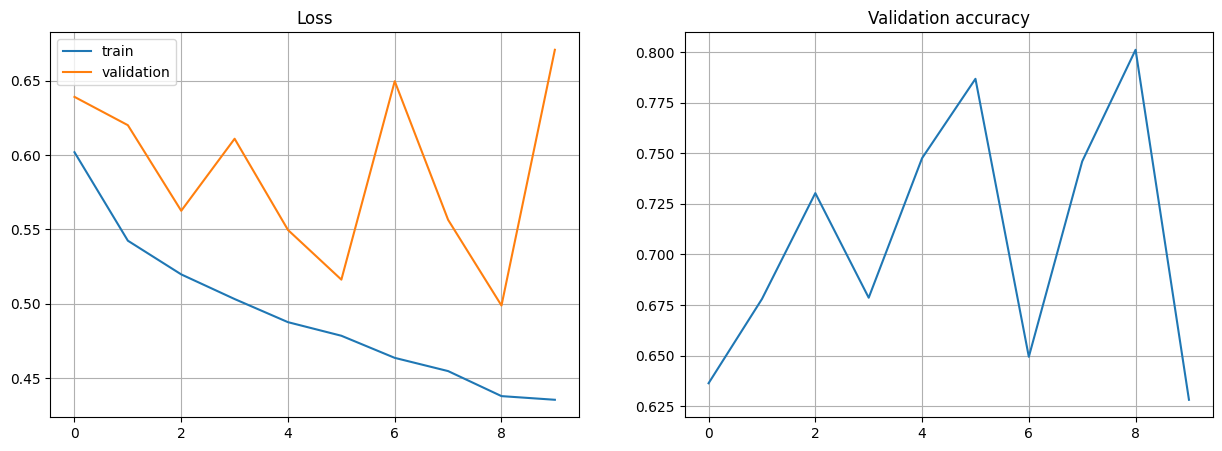

In [51]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluation

In [52]:
val_stats = test_model(best_model_norm, val_loader, "validation")
test_stats = test_model(best_model_norm, test_loader, "test")

Results:
    validation accuracy: 62.81 %
  We need more magic! Follow instructons below
Results:
    test accuracy: 65.59 %
  We need more magic! Follow instructons below



```

```

```

```

```

```

```

```

```

```

```

```

```

```
# Task 4: Data Augmentation (bonus area)

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/augmentation.png?raw=1" width="500">

In [53]:
transformer_augmented = transforms.Compose(
    [
        transforms.RandomRotation(30, fill=tuple((255 * np.array(image_mean)).astype(int))),
        transforms.Resize((5 * SIZE_H // 4, 5 * SIZE_H // 4)),
        transforms.RandomCrop((SIZE_H, SIZE_W)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std),
    ]
)

In [54]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = torchvision.datasets.ImageFolder(
    os.path.join("train_11k"), transform=transformer_augmented
)
train_aug_loader = torch.utils.data.DataLoader(
    train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

Let's look at some image examples

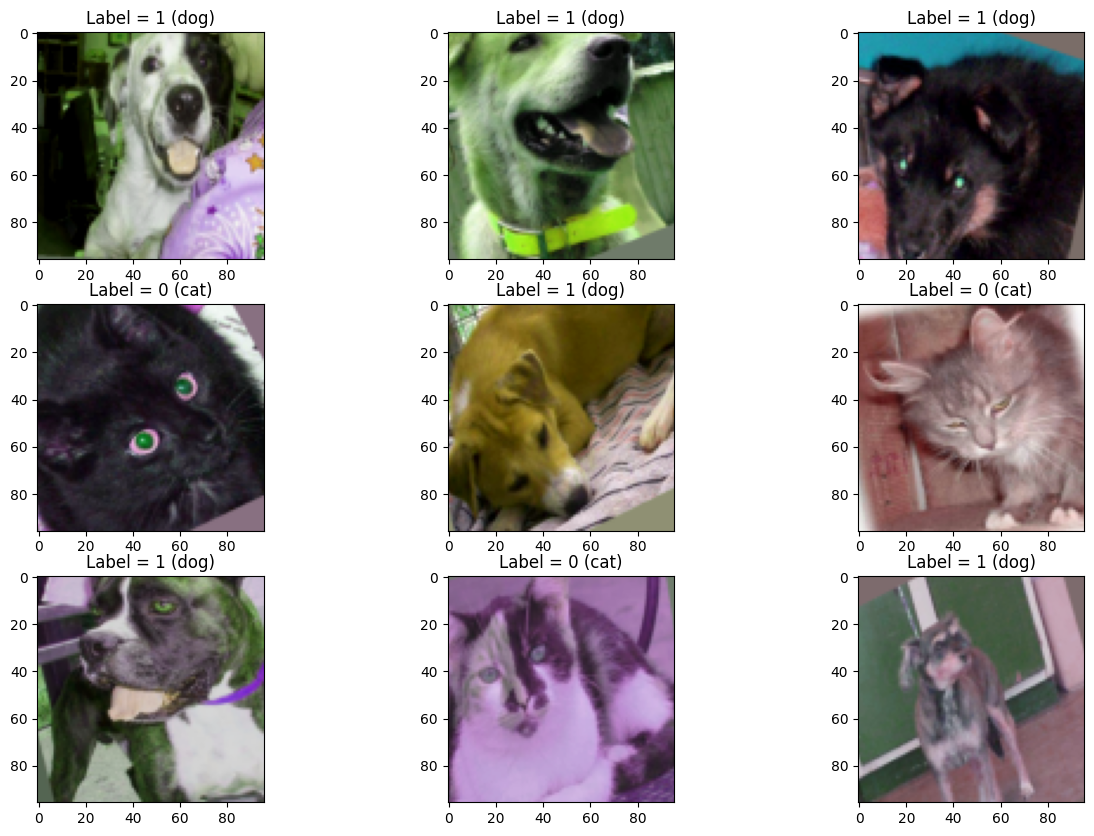

In [55]:
plot_from_loader(train_aug_loader)

Note that we did not change test_dataset, as we do not need to augment image data in it.

Let's retrain our model, saving it to another variable

## Training

In [56]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=1e-3)
opt.zero_grad()

train_loss, val_loss, val_accuracy, best_model_aug = train_model(
    model_cnn_aug, train_aug_loader, val_loader, loss_fn, opt, 10
)

Epoch 1 of 10 took 60.769s
	  training loss: 0.633101
	validation loss: 0.638431
	validation accuracy: 64.6
Epoch 2 of 10 took 62.460s
	  training loss: 0.596212
	validation loss: 0.597117
	validation accuracy: 68.8
Epoch 3 of 10 took 65.598s
	  training loss: 0.565606
	validation loss: 0.620837
	validation accuracy: 66.4
Epoch 4 of 10 took 59.895s
	  training loss: 0.548346
	validation loss: 0.614528
	validation accuracy: 67.4
Epoch 5 of 10 took 63.431s
	  training loss: 0.535155
	validation loss: 0.628101
	validation accuracy: 66.2
Epoch 6 of 10 took 68.988s
	  training loss: 0.526328
	validation loss: 0.569746
	validation accuracy: 72.5
Epoch 7 of 10 took 65.316s
	  training loss: 0.513994
	validation loss: 0.532042
	validation accuracy: 76.7
Epoch 8 of 10 took 63.103s
	  training loss: 0.507243
	validation loss: 0.523030
	validation accuracy: 77.7
Epoch 9 of 10 took 60.461s
	  training loss: 0.501224
	validation loss: 0.618573
	validation accuracy: 67.6
Epoch 10 of 10 took 63.121s


In [ ]:
## Evaluation

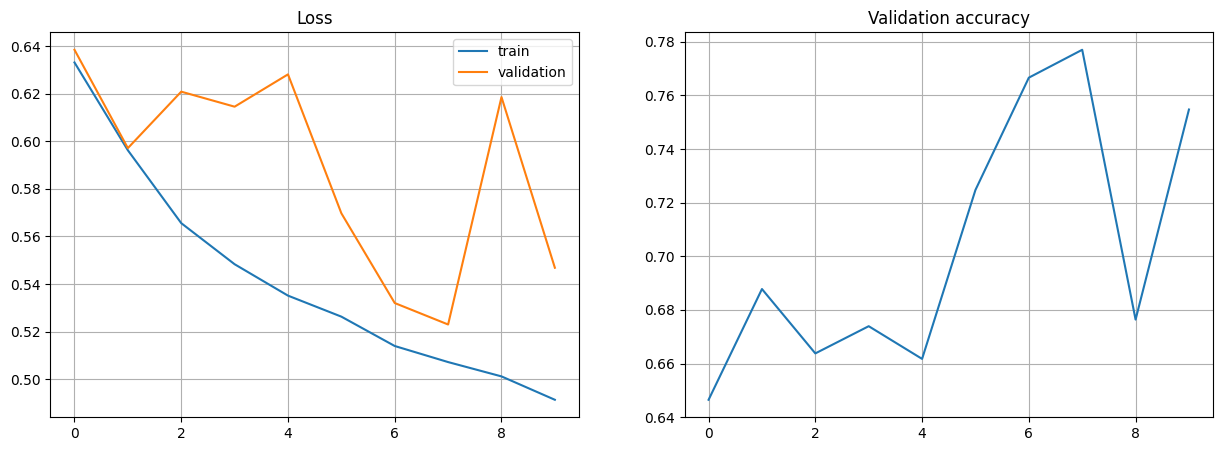

In [57]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [60]:
val_stats = test_model(model_cnn_aug, val_loader, "validation")
test_stats = test_model(model_cnn_aug, test_loader, "test")

Results:
    validation accuracy: 75.48 %
  Good!
Results:
    test accuracy: 77.58 %
  Good!


## Dark Magic (some practical tricks and issues)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/dm.png?raw=1" width="600">

In [61]:
!pip install pytorch-lightning albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 60.4 MB/s eta 0:00:00


In [99]:
import torch
import pytorch_lightning as pl
import albumentations as A
from torch.utils.data import DataLoader, Dataset
import numpy as np
from albumentations import (
    Compose,
    RandomCrop,
    HorizontalFlip,
    RandomBrightnessContrast,
    Normalize,
)
from albumentations.pytorch import ToTensorV2
transformer = A.Compose(
    [
        A.Resize(height=SIZE_H, width=SIZE_W),  # scaling images to fixed size
          # converting to tensors
        A.Normalize(image_mean, image_std),  # normalize image data per-channel
        ToTensorV2(),
    ]
)


# Define your augmentations


def get_train_transforms():
    return A.Compose([
        A.Resize(height=SIZE_H, width=SIZE_W),
        A.Rotate(limit=15),
        A.RandomBrightnessContrast(),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.Resize(height=SIZE_H, width=SIZE_W),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])



In [100]:
train_transformer = get_train_transforms()
val_transformer = get_val_transforms()
test_transformer = get_val_transforms()

In [101]:
class AlbumentationsDataset(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(AlbumentationsDataset, self).__init__(root, transform=transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)

        if self.transform is not None:
            augmented = self.transform(image=np.array(image))
            image = augmented['image']

        return image, target

In [102]:
from torchmetrics import Accuracy

class MyModel_1(pl.LightningModule):
    def __init__(self):
        super(MyModel_1, self).__init__()
        self.model = nn.Sequential(
            conv_block_3x3(3, 64),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            conv_block_3x3(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv_block_3x3(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv_block_3x3(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            conv_block_3x3(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.Dropout(0.3),
            nn.LazyLinear(NUM_CLASSES, bias=False),
            nn.Softmax(dim=1),
        )
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.train_accuracy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.val_accuracy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('test_loss', loss)
        # Optionally, you can log accuracy here
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}


In [103]:
    """
train_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/train_11k",
    transform=transformer
)

val_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/val",
    transform=transformer
)

test_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH / "content/test_labeled",
    transform=transformer
)

"""
train_dataset = AlbumentationsDataset(
    DATA_PATH / "content/train_11k", transform=train_transformer
)
val_dataset = AlbumentationsDataset(
    DATA_PATH / "content/val", transform=val_transformer
)
test_dataset = AlbumentationsDataset(
    DATA_PATH / "content/test_labeled", transform=val_transformer  # Use val transforms for test
)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)





model = MyModel_1()
trainer = pl.Trainer(max_epochs=31)
trainer.fit(model, train_loader, val_loader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | Sequential         | 668 K  | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
668 K     Trainable params
0         Non-trainable params
668 K     Total params
2.672     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=31` reached.


In [104]:
# Test the model
trainer.test(model, test_loader)
trainer.test(model, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9145189523696899     │
│         test_loss         │    0.3953338861465454     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.909600019454956     │
│         test_loss         │    0.40004879236221313    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.40004879236221313, 'test_accuracy': 0.909600019454956}]

In [105]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='my_model-{epoch:02d}-{val_loss:.2f}',  # Filename format
    save_top_k=1,  # Save only the best model
    mode='min',  # Mode to minimize the monitored metric
)

# Create the trainer with the checkpoint callback
trainer = pl.Trainer(max_epochs=31, callbacks=[checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [106]:
# Save the model manually after training
torch.save(model.state_dict(), 'my_model_state_dict.pth')